In [1]:
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)


def get_embedding(text):
    '''Compute GPT3-embedding for a given text string'''
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)


def center_embeddings(df):
    """Offset embeddings by it's center"""
    emb_center = df['embedding'].mean()
    df['embedding'] = df['embedding'].apply(lambda emb: emb - emb_center)


def softmax(x, temp=1.):
    """Compute row-wise softmax of a matrix x"""
    z = np.array(x)
    z -= z.max(axis=1, keepdims=True)
    z = np.exp(z / temp)
    z /= z.sum(axis=1, keepdims=True)
    return z


def get_recs(df1, df2, pref='norm', temp=.1, k=3):
    """Normalize df1-df2 proximity and return k best/worst recommendations"""
    # compute preferences
    if pref == 'norm':
        prefs = [[-np.linalg.norm(e1-e2) for e2 in df2.embedding] for e1 in df1.embedding]
    elif pref == 'dot':
        prefs = [[np.dot(e1, e2) for e2 in df2.embedding] for e1 in df1.embedding]
    elif pref == 'cos':
        prefs = [[np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))\
              for e2 in df2.embedding] for e1 in df1.embedding]
    # normalize preferences
    probs = softmax(prefs, temp=temp)
    print(f'probability distribution:\n{probs}')
    
    # show k best/worst recommendations for each element
    inds = probs.argsort(axis=1)
    for i in range(len(df1)):
        print('\n========================\n')
        print(df1.loc[i].content)
        
        # k best recommendations
        print()
        for j in range(k):
            l = inds[i][~j]
            print(f'#{l} ({100*probs[i][l]:2.0f}%): {df2.loc[l].content}')

        # k worst recommendations
        print()
        for j in range(k):
            l = inds[i][j]
            print(f'#{l} ({100*probs[i][l]:2.0f}%): {df2.loc[l].content}')


def visualize_embeddings():
    """Plot a bunch of unnecessary metrics"""
    embs = np.array(people.embedding.tolist() + messages.embedding.tolist() + images.embedding.tolist())

    # row 1 -- pairwise differences
    fig, ax = plt.subplots(1, 3, figsize=(16,4))

    # plot embedding difference norm
    emb_norm_diff = [[np.linalg.norm(e1-e2) for e2 in embs] for e1 in embs]
    im0 = ax[0].imshow(emb_norm_diff, cmap='pink', vmin=0., vmax=1.)
    ax[0].set_title('pairwise difference norm')
    ax[0].grid(False)
    plt.colorbar(im0, ax=ax[0])

    # plot embedding cosine similarity
    emb_cossim = [[np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)) for e2 in embs] for e1 in embs]
    im1 = ax[1].imshow(emb_cossim, cmap='viridis', vmin=-1., vmax=1.)
    ax[1].set_title('pairwise cosine similarity')
    ax[1].grid(False)
    plt.colorbar(im1, ax=ax[1])

    # plot embedding inner products
    emb_dot = [[np.dot(e1,e2) for e2 in embs] for e1 in embs]
    im2 = ax[2].imshow(emb_dot, cmap='plasma')#, vmin=-1., vmax=1.)
    ax[2].set_title('pairwise inner products')
    ax[2].grid(False)
    plt.colorbar(im2, ax=ax[2])

    plt.tight_layout()
    plt.show()

    # row 2 -- projection embeddings
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    # plot embedding pca
    emb_pca = PCA(n_components=2).fit_transform(embs)
    people_pca, messages_pca, images_pca = np.split(emb_pca, [len(people),-len(images)])
    # plot people pca
    ax[0].scatter(people_pca[:,0], people_pca[:,1], s=100)
    for ind, pnt in enumerate(people_pca):
        ax[0].annotate(f'  p{ind}', pnt)
    # plot messages pca
    ax[0].scatter(messages_pca[:,0], messages_pca[:,1], s=100)
    for ind, pnt in enumerate(messages_pca):
        ax[0].annotate(f'  m{ind}', pnt)
    # plot images pca
    ax[0].scatter(images_pca[:,0], images_pca[:,1], s=100)
    for ind, pnt in enumerate(images_pca):
        ax[0].annotate(f'  i{ind}', pnt)

    # plot embedding tsne
    emb_tsne = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(embs)
    people_tsne, messages_tsne, images_tsne = np.split(emb_tsne, [len(people),-len(images)])
    # plot people tsne
    ax[1].scatter(people_tsne[:,0], people_tsne[:,1], s=100)
    for ind, pnt in enumerate(people_tsne):
        ax[1].annotate(f'  p{ind}', pnt)
    # plot messages tsne
    ax[1].scatter(messages_tsne[:,0], messages_tsne[:,1], s=100)
    for ind, pnt in enumerate(messages_tsne):
        ax[1].annotate(f'  m{ind}', pnt)
    # plot images tsne
    ax[1].scatter(images_tsne[:,0], images_tsne[:,1], s=100)
    for ind, pnt in enumerate(images_tsne):
        ax[1].annotate(f'  i{ind}', pnt)

    plt.tight_layout()
    plt.show()

### Load content and compute embeddings

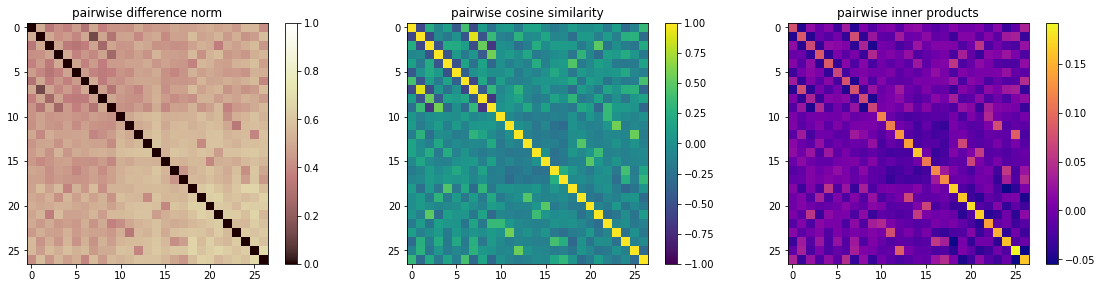

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


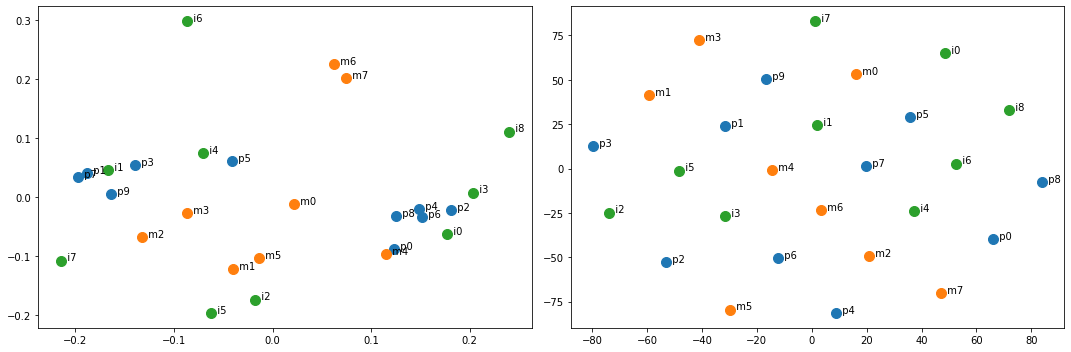

In [2]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')

for df in [people, messages, images]:
    df['embedding'] = df['content'].apply(get_embedding)
    center_embeddings(df)

visualize_embeddings()

### Reduce embedding dimensionality

In [3]:
embs_full = np.array(people.embedding.tolist() + messages.embedding.tolist() + images.embedding.tolist())

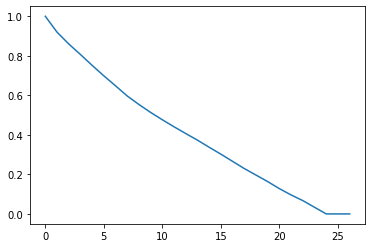

In [4]:
x = np.array(embs_full)
errs = []
for d in range(len(x)):
    pca_proj = PCA(n_components=d)
    y = pca_proj.fit_transform(x)
    z = pca_proj.inverse_transform(y)
    errs.append(np.linalg.norm(x-z))
plt.plot(np.array(errs) / errs[0])
plt.show()

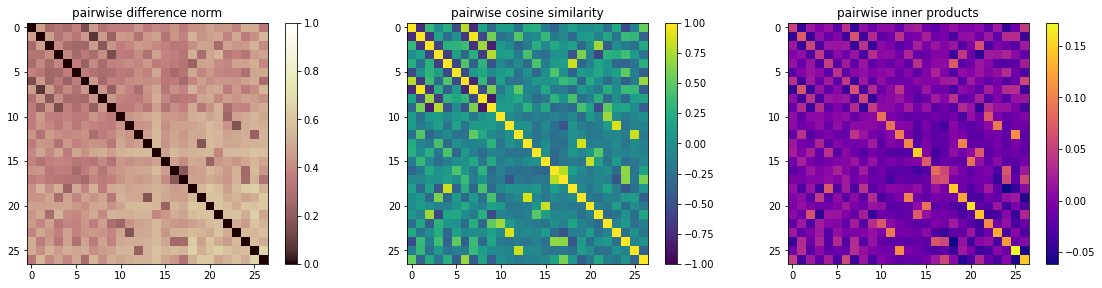

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


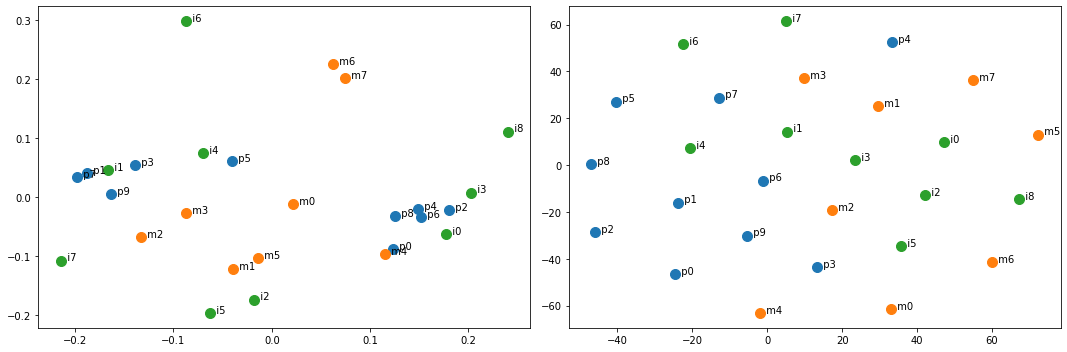

In [5]:
# reduce dimensionality with pca
embs = PCA(n_components=10).fit_transform(embs_full)
# reduce dimensionality with tsne
# embs = TSNE(n_components=10, method='exact', init='pca', learning_rate='auto').fit_transform(embs_full)

people_emb, messages_emb, images_emb = np.split(embs, [len(people),-len(images)])
people.embedding = list(people_emb)
messages.embedding = list(messages_emb)
images.embedding = list(images_emb)

visualize_embeddings()

### Compute recommendations

In [6]:
# people--images
get_recs(people, images, pref='cos', temp=1.)

probability distribution:
[[0.122 0.107 0.104 0.114 0.081 0.133 0.062 0.095 0.182]
 [0.079 0.117 0.119 0.096 0.129 0.086 0.153 0.147 0.074]
 [0.123 0.078 0.105 0.216 0.071 0.104 0.09  0.081 0.132]
 [0.063 0.186 0.089 0.056 0.136 0.129 0.15  0.109 0.08 ]
 [0.24  0.075 0.091 0.123 0.109 0.075 0.072 0.082 0.134]
 [0.074 0.118 0.107 0.131 0.108 0.123 0.176 0.093 0.071]
 [0.137 0.077 0.133 0.103 0.079 0.099 0.071 0.089 0.212]
 [0.077 0.114 0.103 0.089 0.139 0.104 0.154 0.149 0.071]
 [0.165 0.083 0.094 0.141 0.077 0.109 0.079 0.122 0.129]
 [0.075 0.158 0.122 0.061 0.171 0.12  0.124 0.101 0.07 ]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#8 (18%): Young adult African American man walking his dog in the park.
#5 (13%): Person coloring in a coloring book with crayons.
#0 (12%): Young adult Indian man playing guitar and smiling.

#6 ( 6%): Senior white woman biking in the park and loo

In [7]:
# messages--images
get_recs(messages, images, pref='cos', temp=1.)

probability distribution:
[[0.099 0.079 0.115 0.096 0.214 0.103 0.09  0.098 0.107]
 [0.108 0.088 0.083 0.09  0.111 0.251 0.082 0.094 0.093]
 [0.107 0.1   0.087 0.088 0.097 0.098 0.088 0.246 0.088]
 [0.104 0.251 0.09  0.09  0.09  0.1   0.084 0.101 0.09 ]
 [0.117 0.102 0.115 0.178 0.091 0.1   0.097 0.103 0.097]
 [0.091 0.086 0.241 0.118 0.084 0.113 0.082 0.086 0.098]
 [0.118 0.101 0.086 0.097 0.104 0.078 0.208 0.083 0.124]
 [0.098 0.091 0.09  0.096 0.093 0.064 0.197 0.084 0.188]]


Put down your phone and pick up a book! Get lost in a new world, learn something new, or be inspired by a biography. Reading is the perfect escape from screens.

#4 (21%): Young adult asian woman reading a book outside and smiling.
#2 (12%): Person with glasses filling out the newspaper crossword puzzle.
#8 (11%): Young adult African American man walking his dog in the park.

#1 ( 8%): Adult white woman rolling dough in the kitchen and smiling.
#6 ( 9%): Senior white woman biking in the park and looking toward

In [8]:
# people--messages
get_recs(people, messages, pref='cos', temp=1.)

probability distribution:
[[0.139 0.137 0.095 0.156 0.161 0.105 0.088 0.117]
 [0.094 0.104 0.192 0.109 0.118 0.169 0.101 0.112]
 [0.134 0.119 0.088 0.105 0.16  0.114 0.153 0.127]
 [0.133 0.14  0.102 0.185 0.099 0.094 0.122 0.126]
 [0.118 0.098 0.12  0.09  0.191 0.107 0.135 0.14 ]
 [0.129 0.14  0.093 0.122 0.087 0.121 0.189 0.119]
 [0.139 0.098 0.095 0.108 0.133 0.124 0.128 0.176]
 [0.099 0.133 0.2   0.11  0.106 0.15  0.101 0.103]
 [0.124 0.133 0.149 0.112 0.092 0.099 0.164 0.126]
 [0.136 0.136 0.114 0.164 0.112 0.151 0.09  0.097]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#4 (16%): Put down your phone and shuffle the deck! Solitaire is a classic card game that's perfect for passing the time and challenging your mind. Let's get playing!
#3 (16%): Put down your phone and preheat the oven! Baking is a fun and creative way to satisfy your sweet tooth and impress your friends and

### Option 1: Remove dislikes

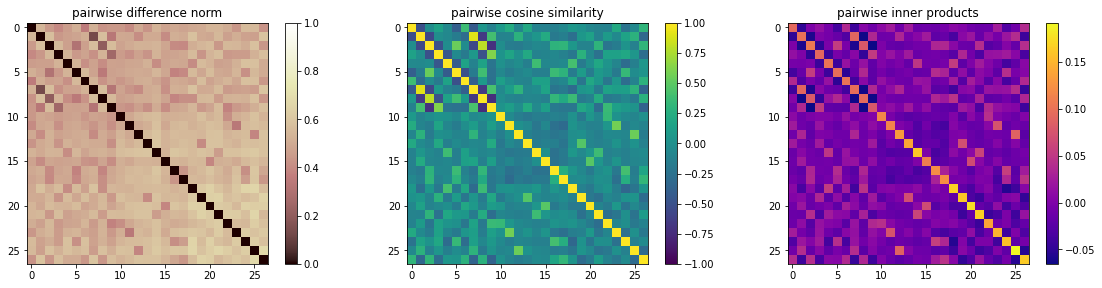

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


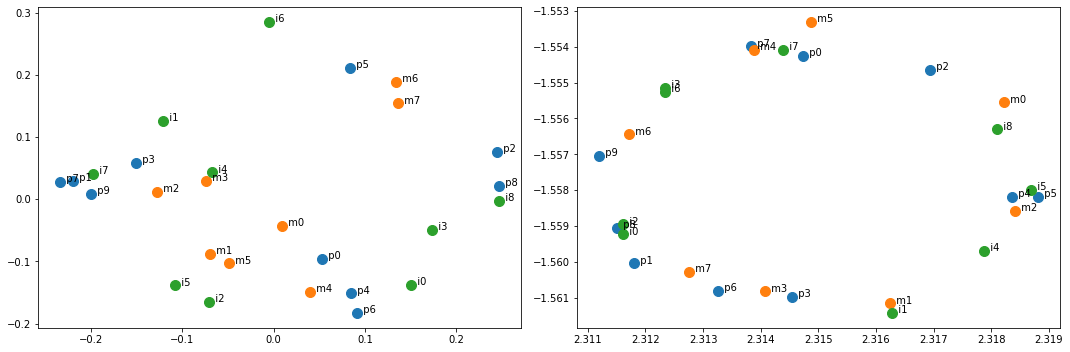

In [9]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')

# remove dislikes
people.content = people.content.apply(lambda p: p.split('\nDislikes: ')[0])

# compute embeddings
for df in [people, messages, images]:
    df['embedding'] = df['content'].apply(get_embedding)
    center_embeddings(df)

visualize_embeddings()

In [10]:
get_recs(people, messages, pref='norm', temp=.1)

probability distribution:
[[0.154 0.228 0.089 0.169 0.061 0.106 0.09  0.103]
 [0.098 0.103 0.225 0.089 0.09  0.231 0.078 0.086]
 [0.114 0.086 0.069 0.072 0.064 0.106 0.24  0.25 ]
 [0.138 0.199 0.113 0.175 0.063 0.114 0.104 0.094]
 [0.134 0.111 0.108 0.076 0.239 0.12  0.102 0.11 ]
 [0.1   0.085 0.079 0.083 0.054 0.093 0.278 0.228]
 [0.18  0.132 0.091 0.082 0.119 0.198 0.094 0.104]
 [0.108 0.164 0.229 0.084 0.073 0.193 0.071 0.077]
 [0.117 0.103 0.081 0.08  0.063 0.101 0.261 0.194]
 [0.136 0.172 0.105 0.172 0.07  0.184 0.083 0.078]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting

#1 (23%): Put down your phone and grab some colored pencils! Coloring books are a fun and creative way to unwind and unleash your inner artist. Let's get coloring!
#3 (17%): Put down your phone and preheat the oven! Baking is a fun and creative way to satisfy your sweet tooth and impress your friends and family. Let's get baking!
#0 (15%): P

In [11]:
get_recs(people, images, pref='norm', temp=.1)

probability distribution:
[[0.109 0.104 0.072 0.073 0.099 0.197 0.06  0.063 0.224]
 [0.051 0.116 0.129 0.072 0.161 0.102 0.155 0.167 0.047]
 [0.107 0.076 0.065 0.215 0.074 0.077 0.108 0.055 0.225]
 [0.057 0.197 0.072 0.051 0.173 0.158 0.161 0.081 0.05 ]
 [0.286 0.062 0.081 0.148 0.131 0.087 0.049 0.05  0.105]
 [0.064 0.126 0.059 0.114 0.129 0.075 0.256 0.07  0.107]
 [0.159 0.059 0.147 0.108 0.078 0.129 0.053 0.056 0.211]
 [0.045 0.107 0.103 0.063 0.182 0.152 0.141 0.163 0.042]
 [0.239 0.063 0.061 0.164 0.077 0.075 0.081 0.046 0.193]
 [0.055 0.147 0.102 0.048 0.281 0.143 0.111 0.072 0.041]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting

#8 (22%): Young adult African American man walking his dog in the park.
#5 (20%): Person coloring in a coloring book with crayons.
#0 (11%): Young adult Indian man playing guitar and smiling.

#6 ( 6%): Senior white woman biking in the park and looking towards the sky.
#7 ( 6%): Per

In [12]:
get_recs(messages, images, pref='norm', temp=.1)

probability distribution:
[[0.095 0.062 0.098 0.075 0.312 0.117 0.088 0.058 0.097]
 [0.076 0.062 0.047 0.053 0.106 0.499 0.054 0.047 0.056]
 [0.08  0.087 0.059 0.058 0.095 0.082 0.072 0.412 0.056]
 [0.084 0.388 0.062 0.062 0.089 0.108 0.071 0.073 0.064]
 [0.111 0.084 0.101 0.305 0.089 0.088 0.072 0.063 0.087]
 [0.069 0.072 0.349 0.1   0.091 0.116 0.07  0.056 0.077]
 [0.097 0.075 0.051 0.082 0.124 0.064 0.314 0.046 0.146]
 [0.081 0.089 0.067 0.093 0.118 0.058 0.2   0.052 0.243]]


Put down your phone and pick up a book! Get lost in a new world, learn something new, or be inspired by a biography. Reading is the perfect escape from screens.

#4 (31%): Young adult asian woman reading a book outside and smiling.
#5 (12%): Person coloring in a coloring book with crayons.
#2 (10%): Person with glasses filling out the newspaper crossword puzzle.

#7 ( 6%): Person knitting at home next to a basket of yarn.
#1 ( 6%): Adult white woman rolling dough in the kitchen and smiling.
#3 ( 7%): Senior hi

### Option 2: Embed people differently

In [89]:
def get_embedding_people(person):
    """Compute embeddings accounting for likes and dislikes"""
    demographics, likes, dislikes = person.replace('\nLikes: ', '|').replace('\nDislikes: ', '|').split('|')
    return get_embedding(demographics)


def include_interests(people):
    """Adjust embeddings for likes and dislikes"""
    for i in range(len(people)):
        person = people.loc[i].content
        _, likes, dislikes = person.replace('\nLikes: ', '|').replace('\nDislikes: ', '|').split('|')

        # positively adjust for likes
        for hobby in likes.split(', '):
            people.loc[i].embedding += .1 * get_embedding(hobby)

        # negatively adjust for dislikes
        for hobby in dislikes.split(', '):
            people.loc[i].embedding -= .1 * get_embedding(hobby)

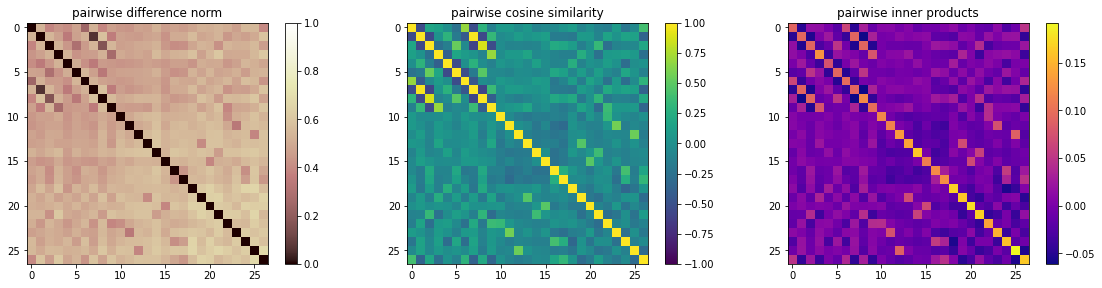

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


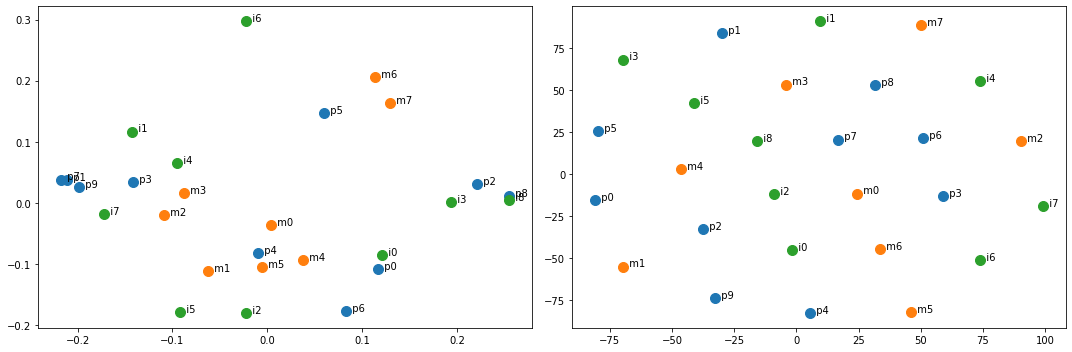

In [90]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')

for df in [messages, images]:
    df['embedding'] = df['content'].apply(get_embedding)
    center_embeddings(df)

# compute demographic embeddings
people['embedding'] = people['content'].apply(get_embedding_people)
center_embeddings(people)

# adjust for people's interests
include_interests(people)

visualize_embeddings()

In [15]:
get_recs(people, messages, pref='norm', temp=.1)

probability distribution:
[[0.158 0.168 0.11  0.123 0.066 0.128 0.112 0.136]
 [0.124 0.138 0.149 0.117 0.102 0.193 0.089 0.088]
 [0.119 0.106 0.088 0.08  0.065 0.148 0.208 0.187]
 [0.127 0.163 0.141 0.168 0.075 0.135 0.1   0.092]
 [0.154 0.142 0.126 0.101 0.118 0.143 0.107 0.108]
 [0.113 0.108 0.108 0.097 0.069 0.133 0.201 0.171]
 [0.163 0.148 0.113 0.109 0.111 0.174 0.081 0.101]
 [0.133 0.172 0.144 0.118 0.09  0.171 0.087 0.085]
 [0.121 0.105 0.078 0.083 0.079 0.149 0.208 0.176]
 [0.134 0.154 0.144 0.17  0.074 0.145 0.096 0.083]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#1 (17%): Put down your phone and grab some colored pencils! Coloring books are a fun and creative way to unwind and unleash your inner artist. Let's get coloring!
#0 (16%): Put down your phone and pick up a book! Get lost in a new world, learn something new, or be inspired by a biography. Reading is the pe

In [16]:
get_recs(people, images, pref='norm', temp=.1)

probability distribution:
[[0.119 0.08  0.086 0.072 0.091 0.143 0.062 0.063 0.283]
 [0.061 0.128 0.106 0.076 0.194 0.124 0.156 0.112 0.045]
 [0.126 0.075 0.087 0.236 0.072 0.091 0.089 0.065 0.158]
 [0.067 0.199 0.095 0.051 0.152 0.147 0.145 0.094 0.05 ]
 [0.183 0.082 0.095 0.095 0.174 0.127 0.06  0.076 0.107]
 [0.084 0.138 0.077 0.138 0.124 0.094 0.177 0.088 0.08 ]
 [0.129 0.072 0.134 0.105 0.074 0.144 0.056 0.071 0.217]
 [0.057 0.125 0.09  0.069 0.214 0.145 0.153 0.104 0.043]
 [0.169 0.063 0.088 0.225 0.078 0.085 0.074 0.049 0.17 ]
 [0.069 0.139 0.086 0.045 0.305 0.121 0.111 0.084 0.041]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#8 (28%): Young adult African American man walking his dog in the park.
#5 (14%): Person coloring in a coloring book with crayons.
#0 (12%): Young adult Indian man playing guitar and smiling.

#6 ( 6%): Senior white woman biking in the park and loo

In [17]:
get_recs(messages, images, pref='norm', temp=.1)

probability distribution:
[[0.095 0.062 0.098 0.075 0.312 0.117 0.088 0.058 0.097]
 [0.076 0.062 0.047 0.053 0.106 0.499 0.054 0.047 0.056]
 [0.08  0.087 0.059 0.058 0.095 0.082 0.072 0.411 0.056]
 [0.084 0.388 0.062 0.062 0.089 0.108 0.071 0.073 0.064]
 [0.111 0.084 0.1   0.305 0.09  0.088 0.072 0.063 0.087]
 [0.069 0.073 0.349 0.1   0.091 0.116 0.07  0.056 0.077]
 [0.097 0.076 0.051 0.082 0.124 0.064 0.313 0.046 0.147]
 [0.081 0.089 0.067 0.093 0.118 0.058 0.2   0.052 0.242]]


Put down your phone and pick up a book! Get lost in a new world, learn something new, or be inspired by a biography. Reading is the perfect escape from screens.

#4 (31%): Young adult asian woman reading a book outside and smiling.
#5 (12%): Person coloring in a coloring book with crayons.
#2 (10%): Person with glasses filling out the newspaper crossword puzzle.

#7 ( 6%): Person knitting at home next to a basket of yarn.
#1 ( 6%): Adult white woman rolling dough in the kitchen and smiling.
#3 ( 7%): Senior hi

## Recommending tuples (person, image, message)

In [91]:
def get_recs_tuple(pref='norm', temp=.1, k=5):
    """Normalize (person,message,image) proximity and return k best/worst recommendations"""
    num_messages = len(messages)
    num_images = len(images)

    # compute normalized preferences
    people_prefs = []
    for p, person_emb in enumerate(people.embedding):
        prefs = np.zeros((num_messages, num_images))
        for i, message_emb in enumerate(messages.embedding):
            for j, image_emb in enumerate(images.embedding):
                prefs[i][j] = np.linalg.norm(person_emb - message_emb)\
                            + np.linalg.norm(person_emb - image_emb)\
                            + 2*np.linalg.norm(message_emb - image_emb)
        probs = softmax(-prefs.reshape(1,-1), temp=temp).reshape(num_messages, num_images)
        people_prefs.append(probs)
        print(probs)

        # show k best recommendations for each person
        print(f'\n{people.loc[p].content}\n')
        for ii, jj in zip(*np.unravel_index(np.argsort(probs, axis=None)[-1:-k-1:-1], probs.shape)):
            print(f'#{jj}/#{ii} ({100*probs[ii][jj]:2.0f}%): '\
                  + f'{images.loc[jj].content}\n{messages.loc[ii].content}\n')
        print('\n================================================\n')

    return people_prefs

In [92]:
prefs = get_recs_tuple()

[[0.007 0.002 0.005 0.002 0.054 0.012 0.003 0.001 0.016]
 [0.008 0.004 0.002 0.002 0.012 0.419 0.002 0.002 0.01 ]
 [0.003 0.002 0.001 0.001 0.003 0.004 0.001 0.044 0.004]
 [0.003 0.045 0.001 0.001 0.003 0.006 0.001 0.001 0.004]
 [0.002 0.001 0.001 0.007 0.001 0.001 0.    0.    0.002]
 [0.003 0.003 0.065 0.004 0.005 0.012 0.002 0.001 0.01 ]
 [0.005 0.002 0.001 0.002 0.006 0.003 0.027 0.001 0.027]
 [0.004 0.003 0.002 0.003 0.006 0.002 0.012 0.001 0.08 ]]

Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#5/#1 (42%): Person coloring in a coloring book with crayons.
Put down your phone and grab some colored pencils! Coloring books are a fun and creative way to unwind and unleash your inner artist. Let's get coloring!

#8/#7 ( 8%): Young adult African American man walking his dog in the park.
Put down your phone and lace up your shoes! Walking is a great way to get some fresh air, clear y